In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

In [2]:
assert len(tf.config.list_physical_devices('GPU')) > 0

In [4]:
mnist = tf.keras.datasets.mnist

(images, labels), (test_images, test_labels) = mnist.load_data()

VAL_SPLIT = 10000

train_images, val_images = images[:images.shape[0] - VAL_SPLIT], images[images.shape[0] - VAL_SPLIT:]
train_labels, val_labels = labels[:images.shape[0] - VAL_SPLIT], labels[images.shape[0] - VAL_SPLIT:]

print(f"Train set shape: {train_images.shape}")
print(f"Validation set shape: {val_images.shape}")
print(f"Test set shape: {test_images.shape}")

Train set shape: (50000, 28, 28)
Validation set shape: (10000, 28, 28)
Test set shape: (10000, 28, 28)


In [5]:
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
val_images = (np.expand_dims(val_images, axis=-1)/255.).astype(np.float32)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)

train_labels = train_labels.astype(np.int64)
val_labels = val_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

print(f"Train set shape: {train_images.shape}")
print(f"Val set shape: {val_images.shape}")
print(f"Test set shape: {test_images.shape}")

Train set shape: (50000, 28, 28, 1)
Val set shape: (10000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)


In [6]:
def plot_images_with_labels(data_length, images, labels, num=20, preds=None):    
    plt.figure(figsize=(10,10), dpi=120)
    random_ints = np.random.choice(data_length, size=num)
    for i in range(num):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.squeeze(images[random_ints[i]]), cmap=plt.cm.binary)
        if preds is not None:
            plt.xlabel(f"P: {np.array([np.argmax(pred) for pred in preds])[random_ints[i]]} | A: {np.squeeze(labels[random_ints[i]])}")
        else:
            plt.xlabel(labels[random_ints[i]])
        plt.xticks([])
        plt.yticks([])

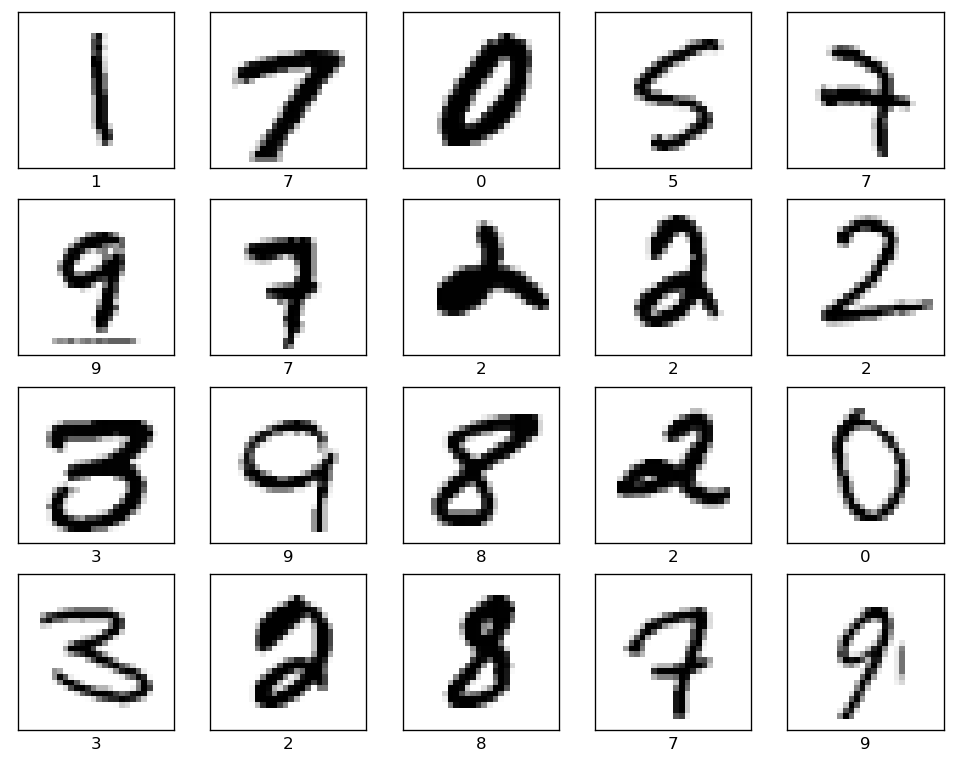

In [7]:
plot_images_with_labels(train_images.shape[0], train_images, train_labels)

In [41]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    return cnn_model

In [19]:
model = build_cnn_model()

LR = 5e-2

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
EPOCHS = 5
BATCH_SIZE = 64

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
782/782 [==============================] - 2s 3ms/step - loss: 0.3827 - accuracy: 0.8807
Epoch 2/5
782/782 [==============================] - 2s 3ms/step - loss: 0.1036 - accuracy: 0.9678
Epoch 3/5
782/782 [==============================] - 2s 3ms/step - loss: 0.0729 - accuracy: 0.9770
Epoch 4/5
782/782 [==============================] - 2s 3ms/step - loss: 0.0587 - accuracy: 0.9809
Epoch 5/5
782/782 [==============================] - 2s 2ms/step - loss: 0.0479 - accuracy: 0.9851


In [21]:
val_loss, val_acc = model.evaluate(val_images, val_labels)

print(f"Validation Loss: {val_loss} | Validation Accuracy: {val_acc}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0815 - accuracy: 0.9770
Validation Loss: 0.08145218342542648 | Validation Accuracy: 0.9769999980926514


In [22]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test Loss: {test_loss} | Test Accuracy: {test_accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9769
Test Loss: 0.07060077786445618 | Test Accuracy: 0.9768999814987183


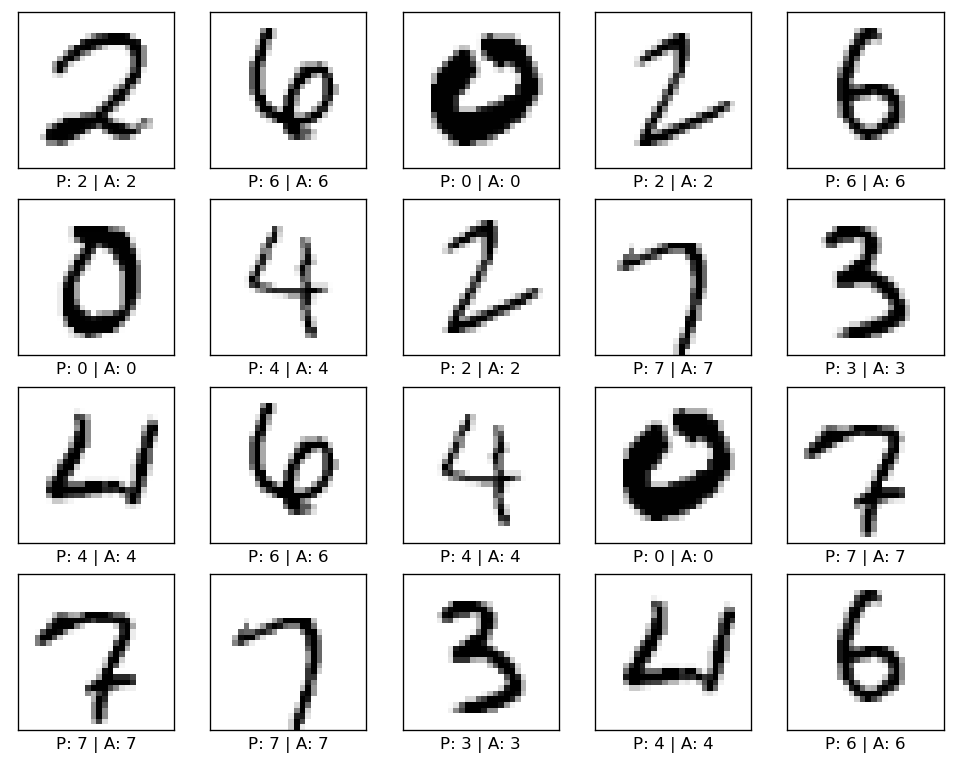

In [24]:
sample_images = test_images[21:42]
sample_labels = test_labels[21:42]

preds = model.predict(sample_images)

plot_images_with_labels(20, sample_images, sample_labels, num=20, preds=preds)

In [28]:
from tqdm import tqdm

In [47]:
# Training using TF GradientTape

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
batch_size = 12

new_model = build_cnn_model()

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
    # get a batch
    (images, labels) = (train_images[idx: idx + batch_size], train_labels[idx: idx + batch_size])
    # convert images to tensor and cast dtype
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    
    # Gradient Tape to record differentiation
    with tf.GradientTape() as tape:
        # feed images to model and get logits
        logits = new_model(images)
        
        # compute loss
        loss = tf.keras.backend.sparse_categorical_crossentropy(labels, logits)
    
    # Backpropagation
    gradients = tape.gradient(loss, new_model.trainable_variables)
    
    # Update weights using optimizer
    optimizer.apply_gradients(zip(gradients, new_model.trainable_variables))

100%|█████████████████████████████████████████████████████████████████████████████| 4167/4167 [00:27<00:00, 150.42it/s]


In [49]:
new_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 36)        7812      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 36)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 900)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               115328    
_________________________________________________________________
dense_21 (Dense)             (None, 10)              

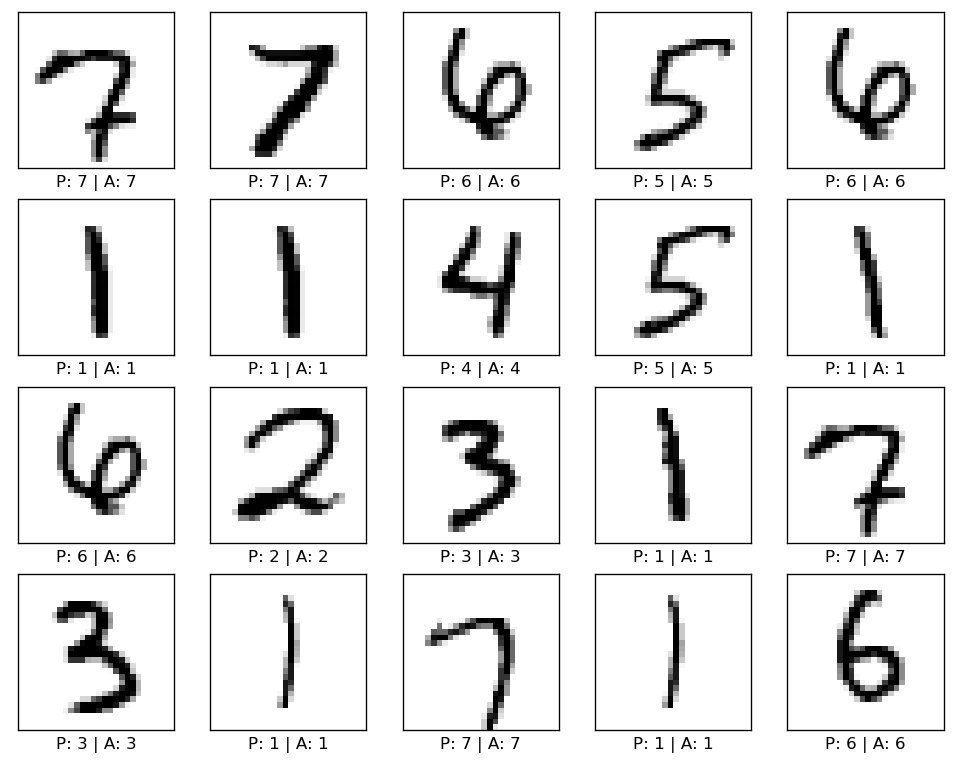

In [50]:
sample_images = test_images[21:42]
sample_labels = test_labels[21:42]

preds = new_model.predict(sample_images)

plot_images_with_labels(20, sample_images, sample_labels, num=20, preds=preds)